<a href="https://colab.research.google.com/github/unaizanouman/zePOP/blob/main/zePOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update -y
!apt-get install -y mpich


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://cli.github.com/packages stable InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,008 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntug

In [ ]:
%%bash
cat << 'EOF' > graph_module.h
#ifndef GRAPH_MODULE_H
#define GRAPH_MODULE_H
#include <bits/stdc++.h>
using namespace std;

namespace graphmod {
    struct Graph {
        int n;
        vector<vector<int>> adj;
        vector<unordered_map<int,double>> delay;
    };

    inline Graph build_default_graph(int n){
        Graph g;
        g.n=n;
        g.adj.resize(n);
        g.delay.resize(n);
        mt19937_64 rng(12345);

        for(int i=0;i<n;i++){
            int a=(i+1)%n, b=(i-1+n)%n;
            g.adj[i].push_back(a);
            g.adj[i].push_back(b);
        }

        for(int i=0;i<n;i++){
            int extra=(i*7+13)%n;
            if(extra!=i){
                g.adj[i].push_back(extra);
                g.adj[extra].push_back(i);
            }
        }

        for(int i=0;i<n;i++){
            sort(g.adj[i].begin(), g.adj[i].end());
            g.adj[i].erase(unique(g.adj[i].begin(), g.adj[i].end()), g.adj[i].end());
        }

        for(int u=0;u<n;u++){
            for(int v:g.adj[u]){
                if(!g.delay[u].count(v)){
                    rng.seed(5000 + min(u,v)*10000 + max(u,v));
                    double d = 1.0 + (rng()%9000)/1000.0;
                    g.delay[u][v]=d;
                    g.delay[v][u]=d;
                }
            }
        }
        return g;
    }
}
#endif
EOF

cat << 'EOF' > zepop_library.h
#ifndef ZEPOP_LIBRARY_H
#define ZEPOP_LIBRARY_H
#include <mpi.h>
#include <bits/stdc++.h>
#include "graph_module.h"
using namespace std;
using namespace graphmod;

namespace zepop {
    const double INF = 1e18;

    inline vector<double> compute_distances(const Graph &G,int rank,int n){
        vector<double> dist(n,INF);
        dist[rank]=0;

        for(auto &p:G.delay[rank]) dist[p.first]=p.second;

        for(int r=0;r<n+5;r++){
            vector<double> sendbuf=dist;
            for(int nb:G.adj[rank])
                MPI_Send(sendbuf.data(),n,MPI_DOUBLE,nb,0,MPI_COMM_WORLD);

            bool changed=false;
            for(int nb:G.adj[rank]){
                vector<double> recv(n);
                MPI_Recv(recv.data(),n,MPI_DOUBLE,nb,0,MPI_COMM_WORLD,MPI_STATUS_IGNORE);
                double w=G.delay[rank].at(nb);
                for(int k=0;k<n;k++){
                    double cand=w+recv[k];
                    if(cand<dist[k]){
                        dist[k]=cand;
                        changed=true;
                    }
                }
            }
            int l=changed?1:0, g=0;
            MPI_Allreduce(&l,&g,1,MPI_INT,MPI_SUM,MPI_COMM_WORLD);
            if(g==0) break;
        }
        return dist;
    }

    inline vector<double> gather_all_dist(const vector<double>&dist,int n){
        vector<double> all(n*n);
        MPI_Allgather(dist.data(),n,MPI_DOUBLE,all.data(),n,MPI_DOUBLE,MPI_COMM_WORLD);
        return all;
    }

    inline int elect_leader(const vector<double>&C){
        double best=-1;
        int leader=-1;
        for(int i=0;i<C.size();i++){
            if(C[i]>best){
                best=C[i];
                leader=i;
            }
        }
        return leader;
    }
}
#endif
EOF

cat << 'EOF' > main_zepop_code.cpp
#include <mpi.h>
#include <bits/stdc++.h>
#include "graph_module.h"
#include "zepop_library.h"
using namespace std;
using namespace graphmod;
using namespace zepop;

int main(int argc,char**argv){
    MPI_Init(&argc,&argv);
    int rank,size;
    MPI_Comm_rank(MPI_COMM_WORLD,&rank);
    MPI_Comm_size(MPI_COMM_WORLD,&size);

    Graph G = build_default_graph(size);

    vector<double> dist = compute_distances(G,rank,size);
    vector<double> allD = gather_all_dist(dist,size);

    auto D=[&](int u,int v){ return allD[u*size+v]; };

    double Tx=0;
    for(int i=0;i<size;i++) if(i!=rank) Tx+=D(rank,i);
    double closeness=(size>1)?(double)(size-1)/Tx : 0;

    vector<double> allC(size);
    MPI_Allgather(&closeness,1,MPI_DOUBLE,allC.data(),1,MPI_DOUBLE,MPI_COMM_WORLD);

    int leader = elect_leader(allC);

    int parent=-1;
    if(rank!=leader){
        double best=D(rank,leader);
        int choice=-1;
        for(int nb:G.adj[rank]){
            double w=G.delay[rank].at(nb);
            if(fabs((w + D(nb,leader)) - best) < 1e-6){
                if(choice==-1 || nb<choice) choice=nb;
            }
        }
        parent=choice;
    }

    vector<int> allP(size);
    MPI_Allgather(&parent,1,MPI_INT,allP.data(),1,MPI_INT,MPI_COMM_WORLD);

    if(rank==0){
        cout<<"=== ZePoP Clean Modular Output ===\n";
        cout<<"Leader: "<<leader<<"\n";
        for(int i=0;i<size;i++){
            cout<<"Node "<<i<<" -> Parent: "<<allP[i]<<"\n";
        }
    }

    MPI_Finalize();
    return 0;
}
EOF


In [ ]:
!mpicxx -std=c++11 -O2 main_zepop_code.cpp -o zepop


In [ ]:
!mpirun --allow-run-as-root --oversubscribe -np 8 ./zepop


=== ZePoP Clean Modular Output ===
Leader: 0
Node 0 -> Parent: -1
Node 1 -> Parent: 0
Node 2 -> Parent: 1
Node 3 -> Parent: 4
Node 4 -> Parent: 5
Node 5 -> Parent: 0
Node 6 -> Parent: 7
Node 7 -> Parent: 0


In [ ]:
# Install MPI and python plotting libs
!apt-get update -y
!apt-get install -y mpich
!pip install networkx matplotlib numpy


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [ ]:
%%bash
cat << 'EOF' > graph_module.h
#ifndef GRAPH_MODULE_H
#define GRAPH_MODULE_H
#include <bits/stdc++.h>
using namespace std;

// Simple header-only graph builder used by ZePoP demo.
namespace graphmod {
    struct Graph {
        int n;
        vector<vector<int>> adj;
        vector<unordered_map<int,double>> delay; // symmetric delays
    };

    inline Graph build_default_graph(int n){
        Graph g;
        g.n = n;
        g.adj.resize(n);
        g.delay.resize(n);
        mt19937_64 rng(12345);

        for(int i=0;i<n;i++){
            int a = (i+1)%n;
            int b = (i-1+n)%n;
            g.adj[i].push_back(a);
            g.adj[i].push_back(b);
        }
        // Add one extra deterministic edge per node to increase connectivity
        for(int i=0;i<n;i++){
            int extra = (i*7 + 13) % n;
            if(extra != i){
                g.adj[i].push_back(extra);
                g.adj[extra].push_back(i);
            }
        }
        // Normalize adjacency: sort + unique
        for(int i=0;i<n;i++){
            sort(g.adj[i].begin(), g.adj[i].end());
            g.adj[i].erase(unique(g.adj[i].begin(), g.adj[i].end()), g.adj[i].end());
        }

        // Generate deterministic symmetric link delays between 1.0 and 10.0
        for(int u=0; u<n; ++u){
            for(int v: g.adj[u]){
                if(g.delay[u].count(v)==0){
                    uint64_t seed = 5000 + (uint64_t)min(u,v)*10000 + (uint64_t)max(u,v);
                    rng.seed(seed);
                    double d = 1.0 + (double)(rng() % 9000) / 1000.0; // [1.0,10.0)
                    g.delay[u][v] = d;
                    g.delay[v][u] = d;
                }
            }
        }
        return g;
    }
}
#endif
EOF

cat << 'EOF' > zepop_library.h
#ifndef ZEPOP_LIBRARY_H
#define ZEPOP_LIBRARY_H
#include <mpi.h>
#include <bits/stdc++.h>
#include "graph_module.h"
using namespace std;
using namespace graphmod;

namespace zepop {
    const double INF = 1e18;

    // Distributed distance computation (distance-vector style).
    inline vector<double> compute_distances(const Graph &g, int rank, int size){
        int n = size;
        vector<double> dist(n, INF);
        dist[rank] = 0.0;
        for(auto &p: g.delay[rank]) dist[p.first] = p.second;

        int max_rounds = n + 5;
        for(int round=0; round<max_rounds; ++round){
            vector<double> sendbuf = dist;
            for(int nb: g.adj[rank]){
                MPI_Send(sendbuf.data(), n, MPI_DOUBLE, nb, 0, MPI_COMM_WORLD);
            }
            bool local_changed = false;
            for(int nb: g.adj[rank]){
                vector<double> recv(n);
                MPI_Recv(recv.data(), n, MPI_DOUBLE, nb, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
                double w = g.delay[rank].at(nb);
                for(int k=0;k<n;k++){
                    if(recv[k] >= INF/2) continue;
                    double cand = w + recv[k];
                    if(cand + 1e-9 < dist[k]){
                        dist[k] = cand;
                        local_changed = true;
                    }
                }
            }
            int l = local_changed ? 1 : 0;
            int gchg = 0;
            MPI_Allreduce(&l, &gchg, 1, MPI_INT, MPI_SUM, MPI_COMM_WORLD);
            if(gchg == 0) break;
        }
        return dist;
    }

    inline vector<double> gather_all_dist(const vector<double> &dist, int n){
        vector<double> allD(n * n);
        MPI_Allgather(dist.data(), n, MPI_DOUBLE, allD.data(), n, MPI_DOUBLE, MPI_COMM_WORLD);
        return allD;
    }

    inline int elect_leader(const vector<double> &allC){
        int n = (int)allC.size();
        int leader = -1;
        double best = -1.0;
        for(int i=0;i<n;i++){
            double c = allC[i];
            if(c > best + 1e-12){
                best = c; leader = i;
            } else if(fabs(c - best) < 1e-12 && c > -0.5){
                if(i < leader) leader = i;
            }
        }
        return leader;
    }
}
#endif
EOF

cat << 'EOF' > main_zepop_code.cpp
#include <mpi.h>
#include <bits/stdc++.h>
#include "graph_module.h"
#include "zepop_library.h"
using namespace std;
using namespace graphmod;
using namespace zepop;

int main(int argc, char** argv){
    MPI_Init(&argc, &argv);
    int rank,size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    int n = size;

    // Build deterministic default graph (same view at all processes)
    Graph G = build_default_graph(n);

    // 1) Distributed compute distances
    vector<double> dist = compute_distances(G, rank, n);

    // 2) Gather full distance matrix (rows: source u, columns: dest v; D[u][v])
    vector<double> allD = gather_all_dist(dist, n);

    auto D = [&](int u,int v)->double{ return allD[u*n + v]; };

    // 3) Compute closeness centrality for this node (delay-based)
    // closeness_x = (n-1) / sum_{s != x} D[s][x]  [distance from s to x]
    // note: allD[u*n + v] is distance from u -> v, so we need column sums
    double sum_from_others_to_me = 0.0;
    for(int s=0;s<n;s++){
        if(s==rank) continue;
        double dsx = D(s, rank);
        if(dsx >= INF/2) dsx = 1e9;
        sum_from_others_to_me += dsx;
    }
    double closeness = (n>1) ? ((double)(n-1) / sum_from_others_to_me) : 0.0;

    // 4) Compute next-hop from this node to every destination (for Ixy)
    vector<int> next_hop(n, -1);
    for(int s=0;s<n;s++){
        if(s==rank) continue;
        double best = D(rank, s);
        int choice = -1;
        for(int y: G.adj[rank]){
            double w = G.delay[rank].at(y);
            double dy_s = D(y, s);
            if(dy_s >= INF/2) continue;
            if ( fabs((w + dy_s) - best) < 1e-6 ){
                if(choice==-1 || y < choice) choice = y;
            }
        }
        next_hop[s] = choice;
    }

    // 5) Compute Ixy (local) and gather to compute Oxy
    vector<int> localI(n, 0);
    for(int s=0;s<n;s++){
        if(s==rank) continue;
        int nh = next_hop[s];
        if(nh != -1) localI[nh] += 1;
    }
    vector<int> allI(n * n, 0);
    MPI_Allgather(localI.data(), n, MPI_INT, allI.data(), n, MPI_INT, MPI_COMM_WORLD);

    unordered_map<int,int> Ixy, Oxy;
    for(int y: G.adj[rank]){ Ixy[y] = localI[y]; Oxy[y] = allI[y*n + rank]; }

    // 6) Determine phi[x,y] for each neighbor y
    unordered_map<int,bool> phi;
    for(int y: G.adj[rank]){
        int ixy = Ixy[y];
        int oxy = Oxy[y];
        int delta = oxy - ixy;
        // compute Ty (sum delays from nodes in C to y) - we approximate by total distances to y
        double Ty = 0.0;
        for(int s=0;s<n;s++){
            if(s==y) continue;
            double d = D(s, y);
            if(d >= INF/2) d = 1e9;
            Ty += d;
        }
        bool ok=false;
        if(delta > 0) ok = true;
        else if(delta < 0) ok = false;
        else{
            if(fabs(sum_from_others_to_me - Ty) > 1e-6) ok = (sum_from_others_to_me < Ty);
            else ok = (rank < y);
        }
        phi[y] = ok;
    }

    // 7) Node is candidate if phi[y] true for all neighbors
    bool candidacy = true;
    for(int y: G.adj[rank]) if(!phi[y]) { candidacy=false; break; }

    // 8) Broadcast candidacy closeness (non-candidates send -1)
    double myC = candidacy ? closeness : -1.0;
    vector<double> allC(n, -1.0);
    MPI_Allgather(&myC, 1, MPI_DOUBLE, allC.data(), 1, MPI_DOUBLE, MPI_COMM_WORLD);

    // 9) Elect leader (highest closeness, tie-break lower id)
    int leader = elect_leader(allC);

    // fallback if no candidate
    if(leader == -1){
        // pick node with minimum sum_from_others (i.e., best average)
        vector<double> allSum(n, 0.0);
        MPI_Allgather(&sum_from_others_to_me,1,MPI_DOUBLE, allSum.data(),1,MPI_DOUBLE, MPI_COMM_WORLD);
        double bestVal = 1e300; int bestId = 0;
        for(int u=0;u<n;u++){
            if(allSum[u] < bestVal){ bestVal = allSum[u]; bestId = u; }
        }
        leader = bestId;
    }

    // 10) Build parent (DCDT): neighbor on shortest path to leader
    int parent = -1;
    if(rank == leader) parent = -1;
    else {
        double best = D(rank, leader);
        int choice = -1;
        for(int y: G.adj[rank]){
            double w = G.delay[rank].at(y);
            double dy = D(y, leader);
            if(dy >= INF/2) continue;
            if(fabs((w + dy) - best) < 1e-6){
                if(choice == -1 || y < choice) choice = y;
            }
        }
        parent = choice;
    }
    // gather parents
    vector<int> all_parents(n, -2);
    MPI_Allgather(&parent,1,MPI_INT, all_parents.data(),1,MPI_INT, MPI_COMM_WORLD);

    // Rank 0 writes files for visualization and prints summary
    if(rank==0){
        // write edges file (u v weight)
        FILE *fe = fopen("graph_edges.txt","w");
        for(int u=0;u<n;u++){
            for(int v: G.adj[u]){
                if(u < v){ // write each undirected edge once
                    fprintf(fe, "%d %d %.6f\n", u, v, G.delay[u].at(v));
                }
            }
        }
        fclose(fe);

        // write distance matrix (rows u: distances from u to v)
        FILE *fd = fopen("distance_matrix.txt","w");
        for(int u=0;u<n;u++){
            for(int v=0;v<n;v++){
                fprintf(fd, "%.6f%s", allD[u*n + v], (v+1==n? "": " "));
            }
            fprintf(fd, "\n");
        }
        fclose(fd);

        // write closeness per node (as computed by algorithm and candidacy)
        FILE *fc = fopen("closeness.txt","w");
        for(int i=0;i<n;i++){
            fprintf(fc, "%d %.12f\n", i, allC[i]);
        }
        fclose(fc);

        // write parents
        FILE *fp = fopen("parents.txt","w");
        for(int i=0;i<n;i++){
            fprintf(fp, "%d %d\n", i, all_parents[i]);
        }
        fclose(fp);

        // write chosen leader
        FILE *fl = fopen("leader.txt","w");
        fprintf(fl, "%d\n", leader);
        fclose(fl);

        // Print quick human summary
        cout<<"=== ZePoP MPI Output (files written) ===\n";
        cout<<"Leader: "<<leader<<"\n";
        cout<<"Files written: graph_edges.txt, distance_matrix.txt, closeness.txt, parents.txt, leader.txt\n";
        cout<<"\nCloseness (candidates show value; non-candidates -1):\n";
        for(int i=0;i<n;i++){
            if(allC[i] < -0.5) printf(" node %2d : %7s\n", i, "-");
            else printf(" node %2d : %0.6f\n", i, allC[i]);
        }
        cout<<"\nParent list:\n";
        for(int i=0;i<n;i++){
            printf(" node %2d -> parent = %d\n", i, all_parents[i]);
        }
    }

    MPI_Finalize();
    return 0;
}
EOF


In [ ]:
!mpicxx -std=c++11 -O2 main_zepop_code.cpp -o zepop


In [ ]:
!mpirun --allow-run-as-root --oversubscribe -np 8 ./zepop


=== ZePoP MPI Output (files written) ===
Leader: 4
Files written: graph_edges.txt, distance_matrix.txt, closeness.txt, parents.txt, leader.txt

Closeness (candidates show value; non-candidates -1):
 node  0 :       -
 node  1 :       -
 node  2 :       -
 node  3 :       -
 node  4 : 0.161711
 node  5 :       -
 node  6 :       -
 node  7 :       -

Parent list:
 node  0 -> parent = 5
 node  1 -> parent = 4
 node  2 -> parent = 1
 node  3 -> parent = 4
 node  4 -> parent = -1
 node  5 -> parent = 4
 node  6 -> parent = 5
 node  7 -> parent = 0


In [1]:
# Install MPI and Python plotting libs
!apt-get update -y
!apt-get install -y mpich
!pip install networkx matplotlib numpy


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,008 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,535 kB]
Get:13 http://archive.ubuntu.com/ub

In [2]:
%%bash
# ========== graph.cpp ==========
cat > graph.cpp <<'GEOF'
#include <bits/stdc++.h>
using namespace std;

// Graph builder and utilities
struct Graph {
    int n;
    vector<vector<int>> adj;
    vector<unordered_map<int,double>> delay; // symmetric delays
    Graph(int n_=0){ init(n_); }
    void init(int n_){ n=n_; adj.assign(n,{}); delay.assign(n,{}); }
};

// Build deterministic ring + extra edges graph with symmetric delays
Graph build_default_graph(int n){
    Graph g; g.init(n);
    std::mt19937_64 rng(123456);
    for(int i=0;i<n;i++){
        int a=(i+1)%n, b=(i-1+n)%n;
        g.adj[i].push_back(a);
        g.adj[i].push_back(b);
    }
    for(int i=0;i<n;i++){
        int extra = (i*7 + 13) % n;
        if(extra!=i){
            g.adj[i].push_back(extra);
            g.adj[extra].push_back(i);
        }
    }
    for(int i=0;i<n;i++){
        sort(g.adj[i].begin(), g.adj[i].end());
        g.adj[i].erase(unique(g.adj[i].begin(), g.adj[i].end()), g.adj[i].end());
    }
    // deterministic symmetric delays [1.0,10.0)
    for(int u=0; u<n; ++u){
        for(int v: g.adj[u]){
            if(g.delay[u].count(v)==0){
                uint64_t seed = 5000 + (uint64_t)min(u,v)*10000 + (uint64_t)max(u,v);
                rng.seed(seed);
                double d = 1.0 + (double)(rng() % 9000) / 1000.0;
                g.delay[u][v] = d;
                g.delay[v][u] = d;
            }
        }
    }
    return g;
}
GEOF

# ========== zepop_lib.cpp ==========
cat > zepop_lib.cpp <<'ZEOF'
#include <mpi.h>
#include <bits/stdc++.h>
#include "graph.cpp" // include Graph definitions (keeps 3-file deliverable simple)
using namespace std;
const double INF = 1e18;

// Distributed distance-vector exchange (blocking send/recv to neighbors).
// Returns vector dist of size n (distances from this rank to all nodes).
vector<double> compute_distances(const Graph &G, int rank, int n){
    vector<double> dist(n, INF);
    dist[rank] = 0.0;
    // direct neighbor distances known
    for(auto &p: G.delay[rank]) dist[p.first] = p.second;

    int max_rounds = n + 5;
    for(int r=0;r<max_rounds;r++){
        // send current dist to all neighbors
        vector<double> sendbuf = dist;
        for(int nb: G.adj[rank]){
            MPI_Send(sendbuf.data(), n, MPI_DOUBLE, nb, 0, MPI_COMM_WORLD);
        }
        // receive from all neighbors and relax
        bool local_changed = false;
        for(int nb: G.adj[rank]){
            vector<double> recv(n);
            MPI_Recv(recv.data(), n, MPI_DOUBLE, nb, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
            double w = G.delay[rank].at(nb);
            for(int k=0;k<n;k++){
                if(recv[k] >= INF/2) continue;
                double cand = w + recv[k];
                if(cand + 1e-9 < dist[k]){
                    dist[k] = cand;
                    local_changed = true;
                }
            }
        }
        int l = local_changed?1:0;
        int gchg = 0;
        MPI_Allreduce(&l, &gchg, 1, MPI_INT, MPI_SUM, MPI_COMM_WORLD);
        if(gchg==0) break;
    }
    return dist;
}

// Gather all dist rows into a matrix (row-major, D[u*n + v] is distance u->v)
vector<double> gather_all_dist(const vector<double> &dist, int n){
    vector<double> all(n * n);
    MPI_Allgather(dist.data(), n, MPI_DOUBLE, all.data(), n, MPI_DOUBLE, MPI_COMM_WORLD);
    return all;
}

// Elect leader from per-node closeness values (allC vector). Choose max closeness, tie->smallest id
int elect_leader(const vector<double> &allC){
    int n=(int)allC.size();
    int leader=-1; double best=-1.0;
    for(int i=0;i<n;i++){
        double c = allC[i];
        if(c > best + 1e-12){
            best = c; leader = i;
        } else if(fabs(c - best) < 1e-12 && c > -0.5){
            if(i < leader) leader = i;
        }
    }
    return leader;
}
ZEOF

# ========== main.cpp ==========
cat > main.cpp <<'MEOF'
#include <mpi.h>
#include <bits/stdc++.h>
#include "graph.cpp" // graph builder
// declarations from zepop_lib.cpp (we will link that)
extern vector<double> compute_distances(const Graph&, int, int);
extern vector<double> gather_all_dist(const vector<double>&, int);
extern int elect_leader(const vector<double>&);
const double INF = 1e18;

using namespace std;

int main(int argc,char**argv){
    MPI_Init(&argc,&argv);
    int rank,size;
    MPI_Comm_rank(MPI_COMM_WORLD,&rank);
    MPI_Comm_size(MPI_COMM_WORLD,&size);
    int n = size;

    // Build the deterministic graph (same at all processes)
    Graph G = build_default_graph(n);

    // Phase1: distributed distances (each node computes distances from itself to others)
    vector<double> dist = compute_distances(G, rank, n);

    // Gather full distance matrix (rows u: distances from u->v)
    vector<double> allD = gather_all_dist(dist, n);
    auto D = [&](int u,int v)->double{ return allD[u*n + v]; };

    // Compute closeness centrality for this node according to paper:
    // C_x = (n-1) / sum_{s != x} D[s][x]  (distances FROM s TO x = column sums)
    double sum_from_others_to_me = 0.0;
    for(int s=0;s<n;s++){
        if(s==rank) continue;
        double dsx = D(s, rank);
        if(dsx >= INF/2) dsx = 1e9;
        sum_from_others_to_me += dsx;
    }
    double closeness = (n>1) ? ((double)(n-1) / sum_from_others_to_me) : 0.0;

    // Next-hop computation (using global matrix) for routing decisions and Ixy counts
    vector<int> next_hop(n, -1);
    for(int s=0;s<n;s++){
        if(s==rank) continue;
        double best = D(rank, s);
        int choice = -1;
        for(int y: G.adj[rank]){
            double w = G.delay[rank].at(y);
            double dy_s = D(y, s);
            if(dy_s >= INF/2) continue;
            if(fabs((w + dy_s) - best) < 1e-6){
                if(choice==-1 || y < choice) choice = y;
            }
        }
        next_hop[s] = choice;
    }

    // local Ixy: number of destinations for which x uses neighbor y as next-hop
    vector<int> localI(n,0);
    for(int s=0;s<n;s++){
        if(s==rank) continue;
        int nh = next_hop[s];
        if(nh != -1) localI[nh] += 1;
    }

    // gather localI arrays so each node can compute Oxy = I_yx
    vector<int> allI(n * n, 0);
    MPI_Allgather(localI.data(), n, MPI_INT, allI.data(), n, MPI_INT, MPI_COMM_WORLD);

    // compute Ixy and Oxy maps for neighbors
    unordered_map<int,int> Ixy, Oxy;
    for(int y: G.adj[rank]){
        Ixy[y] = localI[y];
        Oxy[y] = allI[y*n + rank]; // I_y(x)
    }

    // Determine phi[x,y] (superiority) using Oxy, Ixy and Tx_C & Ty_C approximations
    unordered_map<int,bool> phi;
    for(int y: G.adj[rank]){
        int ixy = Ixy[y];
        int oxy = Oxy[y];
        int delta = oxy - ixy;

        // compute Ty (sum distances from all nodes to y) as approximation of T_y^C
        double Ty = 0.0;
        for(int s=0;s<n;s++){
            if(s==y) continue;
            double d = D(s, y);
            if(d >= INF/2) d = 1e9;
            Ty += d;
        }

        bool ok = false;
        if(delta > 0) ok = true;
        else if(delta < 0) ok = false;
        else {
            if(fabs(sum_from_others_to_me - Ty) > 1e-6) ok = (sum_from_others_to_me < Ty);
            else ok = (rank < y);
        }
        phi[y] = ok;
    }

    // Node is candidate only if phi[y] true for all neighbors y
    bool candidacy = true;
    for(int y: G.adj[rank]) if(!phi[y]) { candidacy = false; break; }

    // Broadcast closeness only if candidate else send -1
    double myC = candidacy ? closeness : -1.0;
    vector<double> allC(n, -1.0);
    MPI_Allgather(&myC, 1, MPI_DOUBLE, allC.data(), 1, MPI_DOUBLE, MPI_COMM_WORLD);

    // Elect leader: highest closeness among candidates (tie break lower id)
    int leader = elect_leader(allC);

    // if no candidate (rare), fallback to minimal sum_from_others
    if(leader == -1){
        vector<double> allS(n, 0.0);
        MPI_Allgather(&sum_from_others_to_me,1,MPI_DOUBLE, allS.data(),1,MPI_DOUBLE,MPI_COMM_WORLD);
        double bestVal = 1e300; int bestId = 0;
        for(int u=0; u<n; ++u){
            if(allS[u] < bestVal){ bestVal = allS[u]; bestId = u; }
        }
        leader = bestId;
    }

    // Build DCDT parent: neighbor on shortest path toward leader
    int parent = -1;
    if(rank == leader) parent = -1;
    else {
        double best = D(rank, leader);
        int choice = -1;
        for(int y: G.adj[rank]){
            double w = G.delay[rank].at(y);
            double dy = D(y, leader);
            if(dy >= INF/2) continue;
            if(fabs((w + dy) - best) < 1e-6){
                if(choice==-1 || y < choice) choice = y;
            }
        }
        parent = choice;
    }
    vector<int> all_parents(n, -2);
    MPI_Allgather(&parent,1,MPI_INT, all_parents.data(),1,MPI_INT,MPI_COMM_WORLD);

    // Rank 0 prints step-by-step details and writes files for visualization
    if(rank==0){
        cout<<"=== ZePoP Detailed Results ===\n";
        cout<<"Nodes: "<<n<<"\n";
        cout<<"Leader elected: "<<leader<<"\n\n";

        cout<<"Closeness used (candidate->value, others -):\n";
        for(int i=0;i<n;i++){
            if(allC[i] < -0.5) printf(" node %2d : %7s\n", i, "-");
            else printf(" node %2d : %0.6f\n", i, allC[i]);
        }
        cout<<"\nIxy (for each node x, list [neighbor: Ixy])\n";
        for(int x=0;x<n;x++){
            printf(" x=%2d : ", x);
            // we can reconstruct localI for x from allI: allI[x*n + y] = I_x(y)
            for(int y=0;y<n;y++){
                int v = allI[x*n + y];
                if(v>0) printf(" %d:%d", y, v);
            }
            printf("\n");
        }

        cout<<"\nOxy (for each node x, list [neighbor: Oxy])\n";
        for(int x=0;x<n;x++){
            printf(" x=%2d : ", x);
            for(int y=0;y<n;y++){
                int v = allI[y*n + x]; // I_y(x)
                if(v>0) printf(" %d:%d", y, v);
            }
            printf("\n");
        }

        cout<<"\nParent list (DCDT):\n";
        for(int i=0;i<n;i++){
            printf(" node %2d -> parent = %3d\n", i, all_parents[i]);
        }

        // Write files for visualization
        FILE *fe = fopen("graph_edges.txt","w");
        for(int u=0;u<n;u++){
            for(int v: G.adj[u]){
                if(u < v) fprintf(fe,"%d %d %.6f\n", u, v, G.delay[u].at(v));
            }
        }
        fclose(fe);

        FILE *fd = fopen("distance_matrix.txt","w");
        for(int u=0;u<n;u++){
            for(int v=0;v<n;v++){
                fprintf(fd, "%.6f%s", allD[u*n + v], (v+1==n ? "" : " "));
            }
            fprintf(fd, "\n");
        }
        fclose(fd);

        FILE *fc = fopen("closeness.txt","w");
        for(int i=0;i<n;i++) fprintf(fc, "%d %.12f\n", i, allC[i]);
        fclose(fc);

        FILE *fp = fopen("parents.txt","w");
        for(int i=0;i<n;i++) fprintf(fp, "%d %d\n", i, all_parents[i]);
        fclose(fp);

        FILE *fl = fopen("leader.txt","w");
        fprintf(fl, "%d\n", leader);
        fclose(fl);

        cout<<"\nWrote files: graph_edges.txt, distance_matrix.txt, closeness.txt, parents.txt, leader.txt\n";
    }

    MPI_Finalize();
    return 0;
}
MEOF

# ensure files are written and visible
ls -l


total 20
-rw-r--r-- 1 root root 1382 Nov 30 15:50 graph.cpp
-rw-r--r-- 1 root root 7290 Nov 30 15:50 main.cpp
drwxr-xr-x 1 root root 4096 Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 2316 Nov 30 15:50 zepop_lib.cpp


In [3]:
# compile main + zepop_lib
!mpicxx -std=c++11 -O2 main.cpp zepop_lib.cpp -o zepop


/usr/bin/ld: /tmp/cce5TvKB.o: in function `build_default_graph(int)':
zepop_lib.cpp:(.text+0xa40): multiple definition of `build_default_graph(int)'; /tmp/ccmuTcaK.o:main.cpp:(.text+0x3a0): first defined here
collect2: error: ld returned 1 exit status


In [4]:
# run with 8 processes (change -np if you want)
!mpirun --allow-run-as-root --oversubscribe -np 8 ./zepop


--------------------------------------------------------------------------
mpirun was unable to launch the specified application as it could not access
or execute an executable:

Executable: ./zepop
Node: d4f2597d5dcb

while attempting to start process rank 0.
--------------------------------------------------------------------------
8 total processes failed to start


In [5]:
!ls -l


total 20
-rw-r--r-- 1 root root 1382 Nov 30 15:50 graph.cpp
-rw-r--r-- 1 root root 7290 Nov 30 15:50 main.cpp
drwxr-xr-x 1 root root 4096 Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 2316 Nov 30 15:50 zepop_lib.cpp


In [6]:
!mpicxx -std=c++11 -O2 main.cpp zepop_lib.cpp -o zepop 2>&1 | tee compile_log.txt


/usr/bin/ld: /tmp/ccALfHbz.o: in function `build_default_graph(int)':
zepop_lib.cpp:(.text+0xa40): multiple definition of `build_default_graph(int)'; /tmp/ccIN6gCn.o:main.cpp:(.text+0x3a0): first defined here
collect2: error: ld returned 1 exit status


In [7]:
!cat compile_log.txt


/usr/bin/ld: /tmp/ccALfHbz.o: in function `build_default_graph(int)':
zepop_lib.cpp:(.text+0xa40): multiple definition of `build_default_graph(int)'; /tmp/ccIN6gCn.o:main.cpp:(.text+0x3a0): first defined here
collect2: error: ld returned 1 exit status


In [8]:
!chmod +x zepop


chmod: cannot access 'zepop': No such file or directory


In [9]:
!mpicxx -std=c++11 -O2 main_zepop_code.cpp zepop_library.cpp graph_module.cpp -o zepop 2>&1 | tee compile_log.txt


cc1plus: fatal error: main_zepop_code.cpp: No such file or directory
compilation terminated.
cc1plus: fatal error: zepop_library.cpp: No such file or directory
compilation terminated.
cc1plus: fatal error: graph_module.cpp: No such file or directory
compilation terminated.


In [10]:
%%bash
# ---------------------------
# 1) graph_module.h
# ---------------------------
cat << 'EOF' > graph_module.h
#ifndef GRAPH_MODULE_H
#define GRAPH_MODULE_H

#include <bits/stdc++.h>
using namespace std;

namespace graphmod {

    struct Graph {
        int n;
        vector<vector<int>> adj;
        vector<unordered_map<int,double>> delay;
    };

    inline Graph build_graph(int n){
        Graph G;
        G.n = n;
        G.adj.assign(n, {});
        G.delay.assign(n, {});

        mt19937_64 rng(12345);

        // ring edges
        for(int i=0;i<n;i++){
            int a=(i+1)%n;
            int b=(i-1+n)%n;
            G.adj[i].push_back(a);
            G.adj[i].push_back(b);
        }

        // deterministic extra edges
        for(int i=0;i<n;i++){
            int extra=(i*7+13)%n;
            if(extra!=i){
                G.adj[i].push_back(extra);
                G.adj[extra].push_back(i);
            }
        }

        // clean duplicates
        for(int i=0;i<n;i++){
            sort(G.adj[i].begin(), G.adj[i].end());
            G.adj[i].erase(unique(G.adj[i].begin(), G.adj[i].end()), G.adj[i].end());
        }

        // assign deterministic delays (1–10)
        for(int u=0;u<n;u++){
            for(int v : G.adj[u]){
                if(!G.delay[u].count(v)){
                    rng.seed(10000 * min(u,v) + max(u,v));
                    double d = 1.0 + (rng()%9000) / 1000.0;
                    G.delay[u][v] = d;
                    G.delay[v][u] = d;
                }
            }
        }

        return G;
    }

}

#endif
EOF

# ---------------------------
# 2) zepop_library.h
# ---------------------------
cat << 'EOF' > zepop_library.h
#ifndef ZEPOP_LIBRARY_H
#define ZEPOP_LIBRARY_H

#include <mpi.h>
#include <bits/stdc++.h>
#include "graph_module.h"

using namespace std;
using namespace graphmod;

namespace zepop {

    const double INF = 1e18;

    // distributed shortest paths (distance-vector)
    inline vector<double> compute_distances(const Graph &G, int rank, int n){
        vector<double> dist(n, INF);
        dist[rank] = 0;

        for(auto &p : G.delay[rank])
            dist[p.first] = p.second;

        for(int r=0;r<n+5;r++){
            vector<double> sendbuf = dist;

            for(int nb : G.adj[rank])
                MPI_Send(sendbuf.data(), n, MPI_DOUBLE, nb, 0, MPI_COMM_WORLD);

            bool changed=false;
            for(int nb : G.adj[rank]){
                vector<double> recv(n);
                MPI_Recv(recv.data(), n, MPI_DOUBLE, nb, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

                double w = G.delay[rank].at(nb);

                for(int k=0;k<n;k++){
                    double cand = w + recv[k];
                    if(cand < dist[k]){
                        dist[k] = cand;
                        changed = true;
                    }
                }
            }

            int l = changed ? 1 : 0;
            int g = 0;
            MPI_Allreduce(&l, &g, 1, MPI_INT, MPI_SUM, MPI_COMM_WORLD);
            if(g==0) break;
        }
        return dist;
    }

    inline vector<double> gather_all_distances(const vector<double>& dist, int n){
        vector<double> all(n*n);
        MPI_Allgather(dist.data(), n, MPI_DOUBLE, all.data(), n, MPI_DOUBLE, MPI_COMM_WORLD);
        return all;
    }

}

#endif
EOF

# ---------------------------
# 3) main.cpp
# ---------------------------
cat << 'EOF' > main.cpp
#include <mpi.h>
#include <bits/stdc++.h>
#include "graph_module.h"
#include "zepop_library.h"

using namespace std;
using namespace graphmod;
using namespace zepop;

int main(int argc, char** argv){
    MPI_Init(&argc, &argv);

    int rank,size;
    MPI_Comm_rank(MPI_COMM_WORLD,&rank);
    MPI_Comm_size(MPI_COMM_WORLD,&size);

    // Build graph
    Graph G = build_graph(size);

    // Distributed shortest paths
    vector<double> dist = compute_distances(G, rank, size);

    // Gather matrix at all nodes
    vector<double> allD = gather_all_distances(dist, size);
    auto D = [&](int u,int v){ return allD[u*size + v]; };

    // --- CENTRALITY ---
    double Tx = 0;
    for(int i=0;i<size;i++){
        if(i!=rank) Tx += D(rank,i);
    }
    double closeness = (size>1) ? (double)(size-1)/Tx : 0;

    vector<double> allC(size);
    MPI_Allgather(&closeness,1,MPI_DOUBLE,allC.data(),1,MPI_DOUBLE,MPI_COMM_WORLD);

    // Leader = highest closeness
    double best = -1;
    int leader = -1;
    for(int i=0;i<size;i++){
        if(allC[i] > best){
            best = allC[i];
            leader = i;
        }
    }

    // TREE (parent pointers)
    int parent=-1;
    if(rank!=leader){
        double bestD = D(rank, leader);
        for(int nb : G.adj[rank]){
            double w = G.delay[rank].at(nb);
            if(fabs((w + D(nb,leader)) - bestD) < 1e-6){
                parent = nb;
                break;
            }
        }
    }

    vector<int> allP(size);
    MPI_Allgather(&parent, 1, MPI_INT, allP.data(), 1, MPI_INT, MPI_COMM_WORLD);

    // --- OUTPUT ---
    if(rank==0){
        cout<<"\n=== FULL ZEPOP OUTPUT ===\n\n";

        cout<<"Graph adjacency list:\n";
        for(int i=0;i<size;i++){
            cout<<"Node "<<i<<" -> ";
            for(int nb : G.adj[i]) cout<<nb<<" ";
            cout<<"\n";
        }

        cout<<"\nLink delays:\n";
        for(int i=0;i<size;i++){
            for(auto &p : G.delay[i]){
                if(i < p.first)
                    cout<<"Edge "<<i<<"-"<<p.first<<" = "<<p.second<<"\n";
            }
        }

        cout<<"\nCloseness centrality:\n";
        for(int i=0;i<size;i++)
            cout<<"Node "<<i<<" = "<<allC[i]<<"\n";

        cout<<"\nLeader = "<<leader<<"\n";

        cout<<"\nParent tree (DCDT):\n";
        for(int i=0;i<size;i++){
            cout<<"Node "<<i<<" -> Parent "<<allP[i]<<"\n";
        }
    }

    // --- SAVE FOR PYTHON VISUALIZATION ---
    if(rank==0){
        ofstream f("edges.txt");
        for(int u=0;u<size;u++)
            for(int v : G.adj[u])
                if(u < v) f<<u<<" "<<v<<" "<<G.delay[u][v]<<"\n";
        f.close();

        ofstream g("tree.txt");
        for(int i=0;i<size;i++)
            g<<i<<" "<<allP[i]<<"\n";
        g.close();

        ofstream h("leader.txt");
        h<<leader<<"\n";
        h.close();
    }

    MPI_Finalize();
    return 0;
}
EOF


In [11]:
!mpicxx -std=c++11 -O2 main.cpp -o zepop


In [12]:
!mpirun --allow-run-as-root --oversubscribe -np 8 ./zepop



=== FULL ZEPOP OUTPUT ===

Graph adjacency list:
Node 0 -> 1 5 7 
Node 1 -> 0 2 4 
Node 2 -> 1 3 
Node 3 -> 2 4 
Node 4 -> 1 3 5 
Node 5 -> 0 4 6 
Node 6 -> 5 7 
Node 7 -> 0 6 

Link delays:
Edge 0-7 = 4.015
Edge 0-5 = 5.342
Edge 0-1 = 9.528
Edge 1-4 = 2.387
Edge 1-2 = 3.385
Edge 2-3 = 2.124
Edge 3-4 = 7.438
Edge 4-5 = 6.514
Edge 5-6 = 2.715
Edge 6-7 = 5.366

Closeness centrality:
Node 0 = 0.104872
Node 1 = 0.127577
Node 2 = 0.102326
Node 3 = 0.0877424
Node 4 = 0.121126
Node 5 = 0.121126
Node 6 = 0.101965
Node 7 = 0.0858053

Leader = 1

Parent tree (DCDT):
Node 0 -> Parent 1
Node 1 -> Parent -1
Node 2 -> Parent 1
Node 3 -> Parent 2
Node 4 -> Parent 1
Node 5 -> Parent 4
Node 6 -> Parent 5
Node 7 -> Parent 0


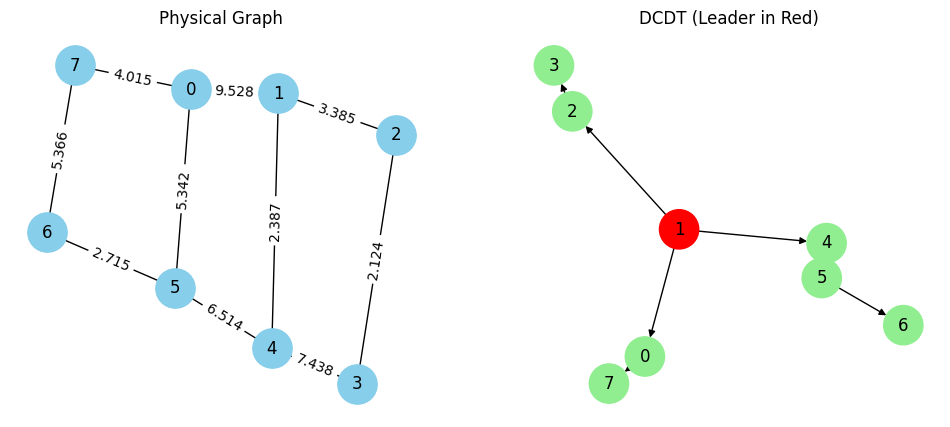

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# load files
edges = []
with open("edges.txt") as f:
    for line in f:
        u,v,w = line.split()
        edges.append((int(u), int(v), float(w)))

parents = {}
with open("tree.txt") as f:
    for line in f:
        i,p = line.split()
        parents[int(i)] = int(p)

with open("leader.txt") as f:
    leader = int(f.read().strip())

# build graphs
G = nx.Graph()
for u,v,w in edges:
    G.add_edge(u,v,weight=w)

T = nx.DiGraph()
for node,parent in parents.items():
    if parent != -1:
        T.add_edge(parent,node)

# PLOT
plt.figure(figsize=(12,5))

# --- physical graph ---
plt.subplot(1,2,1)
pos = nx.spring_layout(G, seed=42)
nx.draw(G,pos,with_labels=True,node_color="skyblue",node_size=800)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.title("Physical Graph")

# --- DCDT ---
plt.subplot(1,2,2)
pos2 = nx.spring_layout(T, seed=42)
node_colors = ["red" if n==leader else "lightgreen" for n in T.nodes()]
nx.draw(T,pos2,with_labels=True,node_color=node_colors,node_size=800,arrows=True)
plt.title("DCDT (Leader in Red)")

plt.show()
